In [1]:
%%capture
%run full_setup.py

In [30]:
from tfidf_corpus_dictionary import get_tfidf_tokendocs_corpus_dict
from gensim.models import LdaModel, LsiModel, CoherenceModel
from sklearn.decomposition import NMF, PCA
from sklearn.random_projection import GaussianRandomProjection
import numpy as np
from scipy import sparse
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
tfidf_matrix, feature_names, tokenized_docs, corpus, dictionary = get_tfidf_tokendocs_corpus_dict(df, max_df=0.5, min_df=5, max_features=1000)

In [4]:
from coherence_by_topics import coherence_by_topics
from coherence_by_words import coherence_by_words

In [5]:
topics = [5, 10, 20, 50]

In [6]:
evaluation_by_topics = {}

for n_topics in topics:
    metrics_words = coherence_by_topics(n = n_topics, corpus=corpus, dictionary=dictionary,
                               texts=tokenized_docs, feature_names=feature_names, tfidf=tfidf_matrix)
    
    evaluation_by_topics[n_topics] = metrics_words

In [7]:
evaluation_by_topics[5]

[('LDA', 0.6208),
 ('LSA', 0.4647),
 ('NMF', 0.7424),
 ('PCA', 0.5965),
 ('RP', 0.3343)]

In [8]:
evaluation_by_topics[10]

[('LDA', 0.4748),
 ('LSA', 0.5019),
 ('NMF', 0.7351),
 ('PCA', 0.5063),
 ('RP', 0.3053)]

In [9]:
evaluation_by_topics[20]

[('LDA', 0.4448),
 ('LSA', 0.4515),
 ('NMF', 0.6781),
 ('PCA', 0.428),
 ('RP', 0.3003)]

In [10]:
evaluation_by_topics[50]

[('LDA', 0.3998),
 ('LSA', 0.3892),
 ('NMF', 0.5852),
 ('PCA', 0.3908),
 ('RP', 0.2972)]

In [11]:
words = [10, 100, 1000, 10000]

In [12]:
evaluation_by_words = {}

for n_words in words:
    metrics_words = coherence_by_words(df, n = n_words)
    evaluation_by_words[n_words] = metrics_words

In [13]:
evaluation_by_words[10]

[('LDA', 0.2872),
 ('LSA', 0.2872),
 ('NMF', 0.2872),
 ('PCA', 0.2872),
 ('RP', 0.2872)]

In [14]:
evaluation_by_words[100]

[('LDA', 0.5621),
 ('LSA', 0.5046),
 ('NMF', 0.5817),
 ('PCA', 0.49),
 ('RP', 0.4515)]

In [15]:
evaluation_by_words[1000]

[('LDA', 0.6208),
 ('LSA', 0.4647),
 ('NMF', 0.7424),
 ('PCA', 0.5965),
 ('RP', 0.3343)]

In [16]:
evaluation_by_words[10000]

[('LDA', 0.5122),
 ('LSA', 0.6993),
 ('NMF', 0.7772),
 ('PCA', 0.7429),
 ('RP', 0.6483)]

In [25]:
def tables(evaluation, type: str):
    # Specify the results folder
    results = R"results"
    results_folder = os.path.join(path, results)

    # Create individual DataFrames for each specific number
    dfs = {}
    for n, values in evaluation.items():
        dfs[n] = pd.DataFrame(values, columns=['Model', 'Coherence'])

    # Save each DataFrame as a PNG file with a title in the specified folder
    for n, df in dfs.items():
        fig, ax = plt.subplots(figsize=(4, 3))  # Adjust the figure size
        ax.axis('off')  # Turn off the axis

        # Set the width of the columns
        col_width = 1.0 / len(df.columns)
        cell_data = [df.columns] + df.values.tolist()  # Include column names as the first row
        table = ax.table(cellText=cell_data, loc='center', cellLoc='center', colLabels=None, edges='open')

        # Make column labels bold
        for (i, j), cell in table.get_celld().items():
            if i == 0:
                cell.set_text_props(fontweight='bold')

        # Adjust column width
        table.auto_set_column_width([0, 1])

        # Adjust the position of the table within the figure
        table.set_fontsize(13)  # Adjust font size
        table.scale(1, 2)  # Scale the table

        ax.set_title(f'Coherence with {n} {type}', fontsize=18, y=0.95)  # Add a title

        filename = os.path.join(results_folder, f'table_{n}_{type}.png')
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)  # Adjust padding
        plt.close()  # Close the figure to avoid overlapping when saving multiple files

In [26]:
tables(evaluation_by_topics, 'topics')

In [27]:
tables(evaluation_by_words, 'words')

In [31]:
def plots(evaluation, type: str):
    figures = R'figures'
    figures_folder = os.path.join(path, figures)
        
    for n, metrics in evaluation.items():
        model_names, coherence_values = zip(*metrics)

        # Create a DataFrame for easy plotting with Seaborn
        data = {'Model': model_names, 'Coherence Value': coherence_values}
        df = pd.DataFrame(data)

        plt.figure(figsize=(8, 5))
        
        # Use Seaborn's barplot with the hue parameter
        sns.barplot(x='Model', y='Coherence Value', data=df, hue='Model', palette='viridis')
        
        plt.xlabel('Model')
        plt.ylabel('Coherence Value')
        plt.title(f'Coherence Evaluation for {n} {type}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        save_path = os.path.join(figures_folder, f'coherence_evaluation_{n}_{type}')
        
        plt.savefig(save_path)
        plt.show()

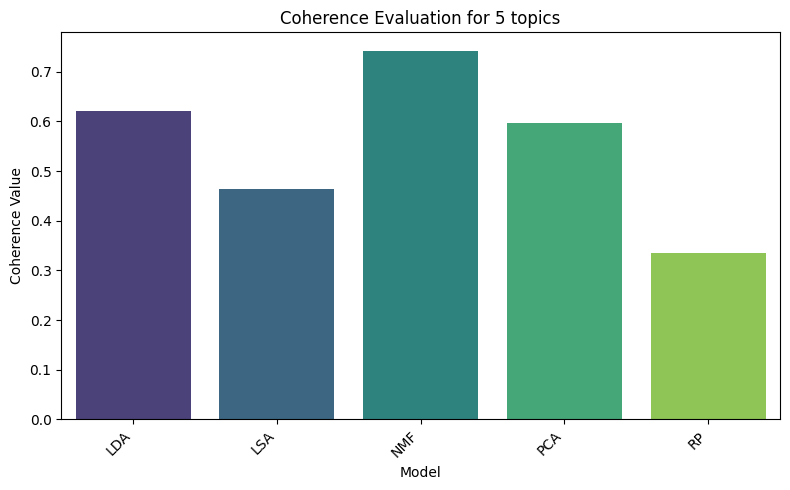

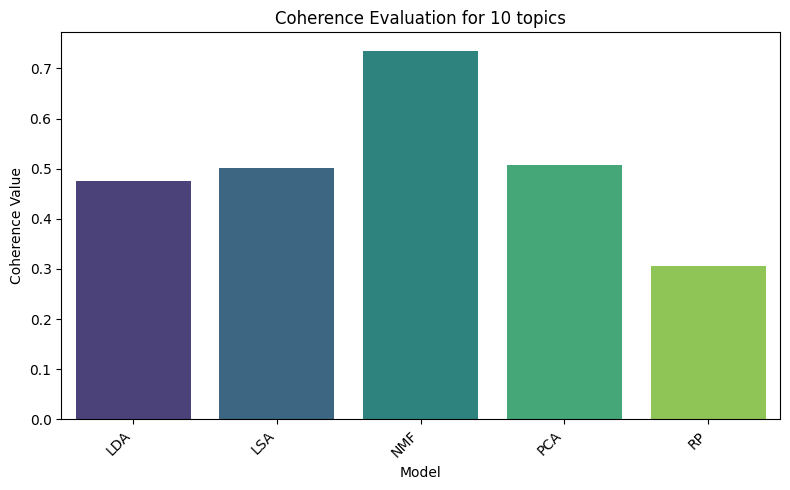

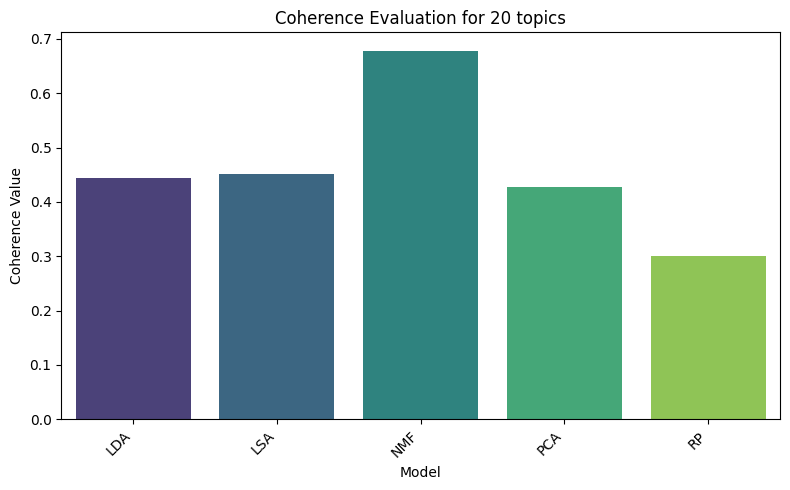

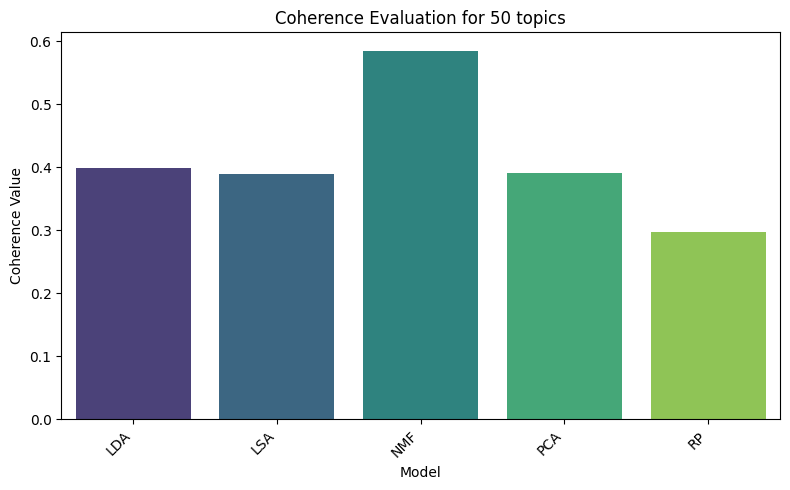

In [32]:
plots(evaluation_by_topics, 'topics')

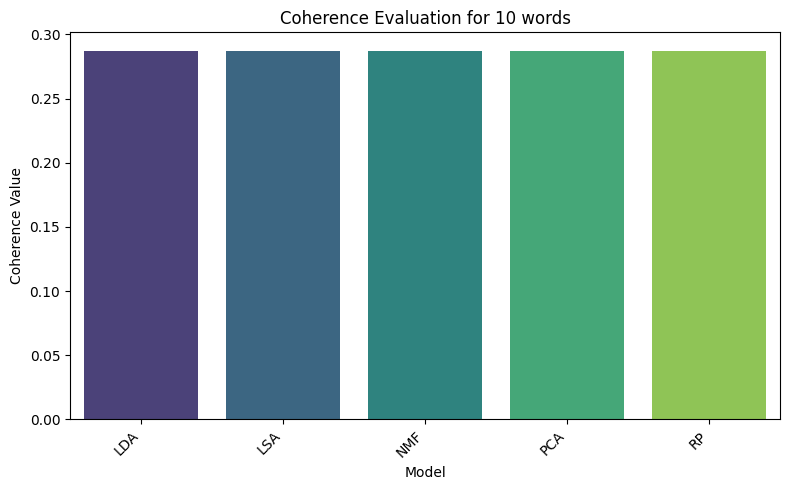

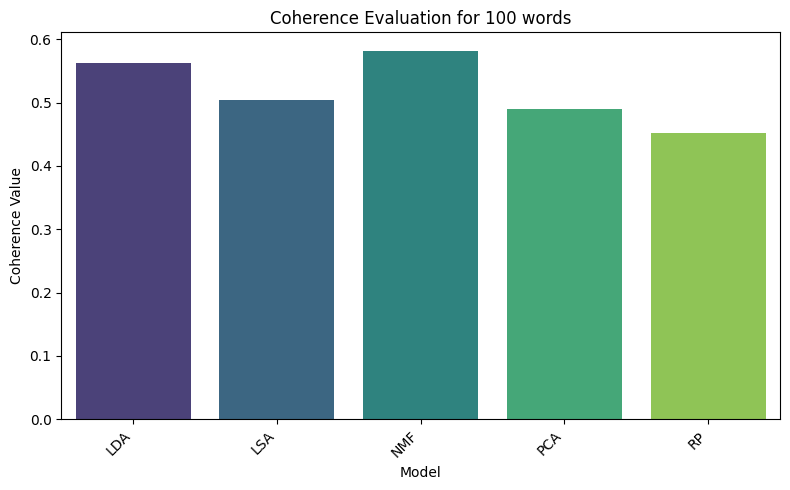

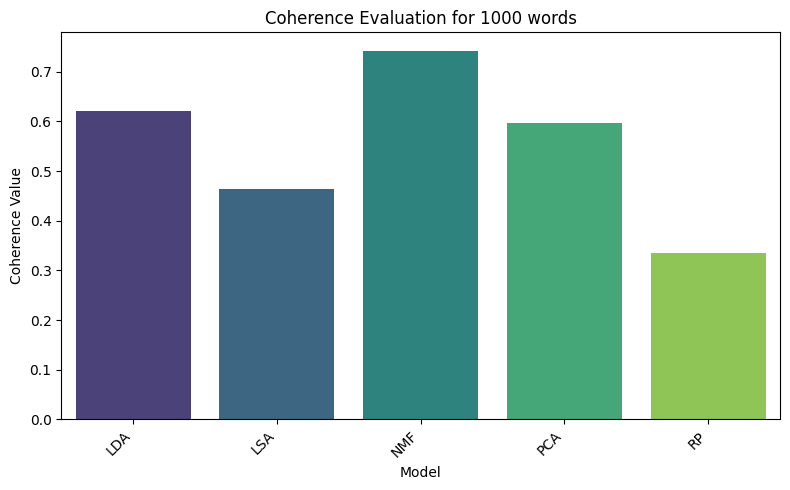

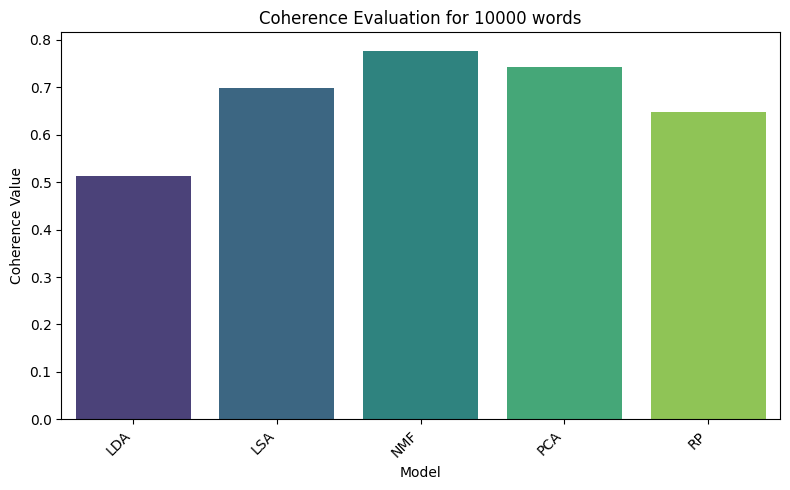

In [33]:
plots(evaluation_by_words, 'words')

In [ ]:
from display_topics import display_topics

In [ ]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5,
                     alpha='symmetric', eta='auto', passes=5, random_state=1)

In [ ]:
display_topics('LDA', lda_model, feature_names)

In [ ]:
lsi_model = LsiModel(corpus, id2word=dictionary, num_topics=5, random_seed = 1)

In [ ]:
display_topics('LSA', lsi_model, feature_names)

In [ ]:
nmf_model = NMF(n_components=5, random_state=1).fit(tfidf_matrix)

In [ ]:
display_topics('NMF', nmf_model, feature_names)

In [ ]:
tfidf_matrix_dense = tfidf_matrix.todense() if sparse.issparse(tfidf_matrix) else tfidf_matrix

# Convert to numpy array
tfidf_matrix_array = np.asarray(tfidf_matrix_dense)

# Centering
mean_tfidf = np.mean(tfidf_matrix_array, axis=0)  # Calculate the mean of each column
centered_tfidf_matrix = tfidf_matrix_array - mean_tfidf

pca_model = PCA(n_components=5, random_state=1).fit(centered_tfidf_matrix)

In [ ]:
display_topics('PCA', pca_model, feature_names)

In [ ]:
rp_model = GaussianRandomProjection(n_components=5, random_state=1).fit(tfidf_matrix)

In [ ]:
display_topics('RP', rp_model, feature_names)